# EPIC action recognition start kit

Welcome to the EPIC action recognition start kit! Let's get your feet wet playing around with the dataset!

We're going to show you how this demo project is set up and how to use the dataset and tools we provide to get a feel for how to utilise the dataset in your own projects.

The first thing to note is we provide a [snakemake](https://snakemake.readthedocs.io/en/stable/) `Snakefile` that orchestrates the data processing pipeline: from downloading all the rgb/flow frames and labels to processing the data into a format suitable for use with training loops. You should ensure you have run `snakemake download_metadata` before running this notebook as we'll use some of the files created.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid') # Use seaborn defaults for plotting

First we'll load in the annotations and verb/noun classes, defining a few helper methods to convert from numeric verb/noun classes to human-readable verbs/nouns.

We'll build the snakemake targets in case the labels haven't been built or the cluster classes haven't been downloaded

In [2]:
%%bash 
cd ..
snakemake data/raw/EPIC_{verb,noun}_classes.csv data/processed/train_labels.pkl

Building DAG of jobs...
Nothing to be done.
Complete log: /jmain01/home/JAD026/dxd01/wwp62-dxd01/action-recognition-starter-kit/.snakemake/log/2018-09-05T175955.276227.snakemake.log


In [3]:
from ast import literal_eval
verb_classes = pd.read_csv('../data/raw/EPIC_verb_classes.csv', converters={ 'verbs': literal_eval }, index_col='verb_id')
noun_classes = pd.read_csv('../data/raw/EPIC_noun_classes.csv', converters={ 'nouns': literal_eval }, index_col='noun_id')
train_labels = pd.read_pickle('../data/processed/train_labels.pkl')
test_seen_labels = pd.read_pickle('../data/processed/test_seen_labels.pkl')
test_unseen_labels = pd.read_pickle('../data/processed/test_unseen_labels.pkl')
labels = pd.concat([train_labels, test_seen_labels, test_unseen_labels], sort=False)

def class_to_verb(cls):
    return verb_classes['class_key'].loc[cls]
    
def class_to_noun(cls):
    return noun_classes['class_key'].loc[cls]
    
print(class_to_verb(0))
print(class_to_noun(0))

take
Nothing


Let's have a look at what the annotations dataframe looks like and the data stored within

In [4]:
labels.head()

,participant_id,video_id,narration,start_timestamp,stop_timestamp,start_frame,stop_frame,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes
uid,,,,,,,,,,,,,
0,P01,P01_01,open door,00:00:00.14,00:00:03.37,8,202,open,2.0,door,8.0,[door],[8]
1,P01,P01_01,turn on light,00:00:04.37,00:00:06.17,262,370,turn-on,12.0,light,113.0,[light],[113]
2,P01,P01_01,close door,00:00:06.98,00:00:09.49,418,569,close,3.0,door,8.0,[door],[8]
3,P01,P01_01,open fridge,00:00:12.77,00:00:13.99,766,839,open,2.0,fridge,10.0,[fridge],[10]
4,P01,P01_01,take celery,00:00:15.25,00:00:16.40,915,983,take,0.0,celery,185.0,[celery],[185]


You can find details of what each of these columns are and the values they can take from the [annotations documentation]( https://github.com/epic-kitchens/annotations#epic_train_action_labelscsv)

Participants describe the actions they are performing in unstructured language, you can see how they describe each action in the `narration` column, these are processed to obtain an action verb stored in the `verb` column and nouns stored in the `all_nouns` column. The verbs and nouns are then clustered so that similar verbs are grouped together and likewise for nouns, these groups are listed in the `verb_classes` and `noun_classes` variables. The clustered verb and nouns are stored in `verb_class` and `all_noun_classes` respectively.

Now we'll have a look at the train/test split examining the sizes of each set and the number of unique verbs and nouns

In [5]:
len(train_labels), len(test_seen_labels), len(test_unseen_labels)

(28472, 8047, 2929)

In [6]:
len(labels)

39448

In [7]:
# Number of unique verb classes in training
len(train_labels.verb_class.unique())

119

In [8]:
# Number of unique noun classes in training
from functools import reduce
len(np.unique(list(reduce(lambda a, b: a + b, train_labels.all_noun_classes))))

325

Now we'll have a look at the distribution of verbs and nouns across the training split.

In [9]:
%matplotlib inline

def plot_verb_dist(labels, title='Verb distribution'):
    fig, ax = plt.subplots(1, 1, figsize=(6, 20))
    labels.verb_class.apply(class_to_verb).value_counts().sort_values().plot(kind='barh', logx=True)
    plt.xlabel('Verb counts')
    plt.ylabel('Verb')
    plt.title(title)
    
    
def plot_noun_dist(labels, title='Noun distribution'):
    fig, ax = plt.subplots(1, 1, figsize=(6, 45))
    labels.noun_class.apply(class_to_noun).value_counts().sort_values().plot(kind='barh', logx=True)
    plt.xlabel('Noun counts')
    plt.ylabel('Noun')
    plt.title(title)

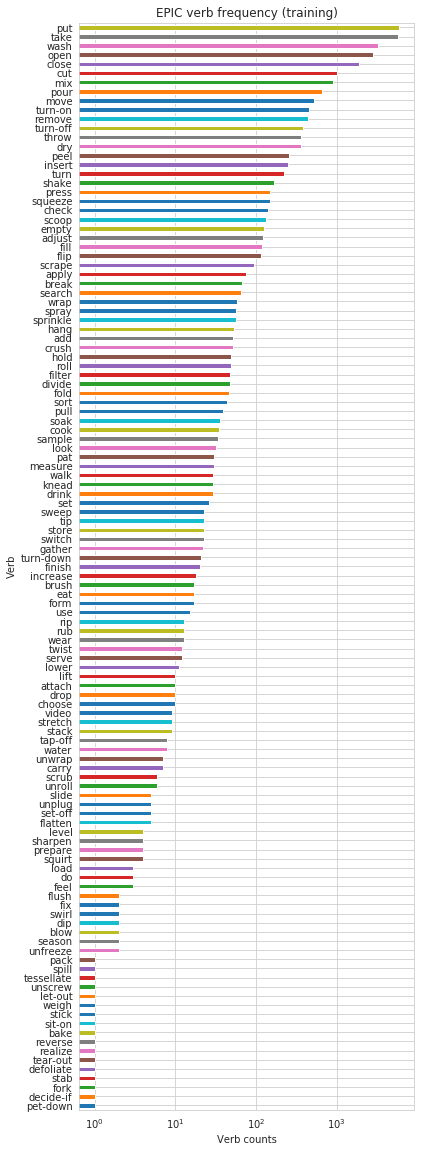

In [10]:
plot_verb_dist(train_labels, title='EPIC verb frequency (training)')

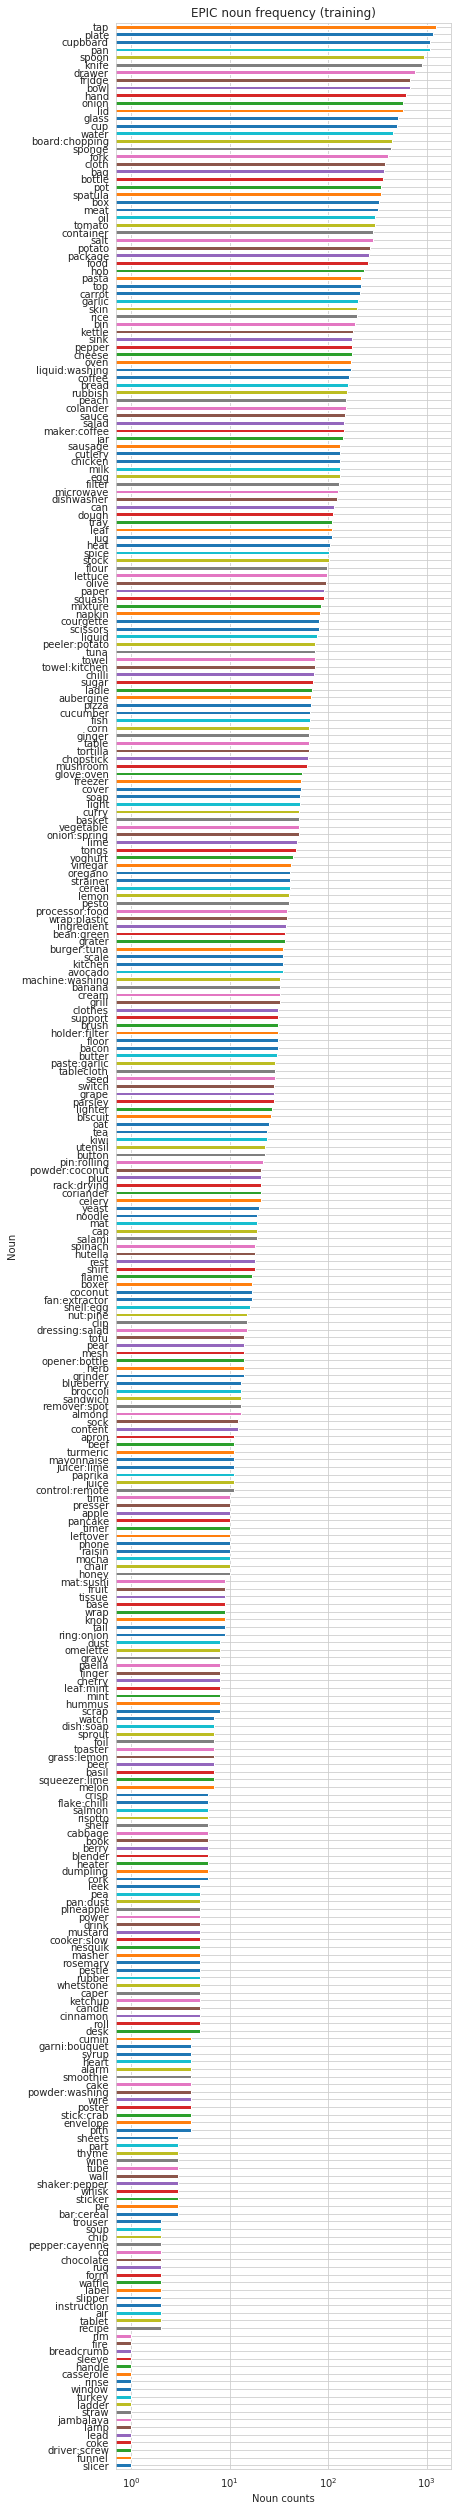

In [11]:
plot_noun_dist(train_labels, title='EPIC noun frequency (training)')